## 다층 퍼셉트론을 구현하고, 딥 러닝을 통해서 숫자 필기 데이터를 분류해본다.

### 1. 숫자 필기 데이터 소개

숫자 필기 데이터는 사이킷런 패키지에서 제공하는 분류용 예제 데이터이다.  
8 * 8 = 64 픽셀 해상도의 흑백 이미지로,  
0부터 15까지의 명암을 갖는다.  
해당 이미지는 총 1,797개 있다.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits() # 1,979개의 이미지 데이터 로드

첫 번째 샘플을 출력해보자.

In [3]:
print(digits.images[0])

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


첫번째 샘플의 레이블을 확인해보자.

In [4]:
print(digits.target[0])

0


전체 샘플의 수를 확인해보자.

In [5]:
print(f'전체 샘플의 수 : {len(digits.images)}')

전체 샘플의 수 : 1797


상위 5개 샘플을 시각화해보자

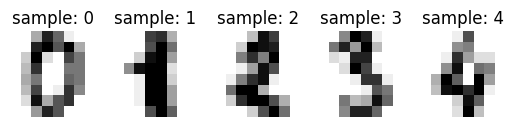

In [6]:
images_and_labels = list(zip(digits.images, digits.target))

for index, (image, label) in enumerate(images_and_labels[:5]): # 5개의 샘플만 출력
    plt.subplot(2,5,index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r,interpolation='nearest')
    plt.title('sample: %i' % label)

상위 5개 샘플의 레이블을 확인해보자.

In [7]:
for i in range(5):
    print(i, '번 인덱스 샘플의 레이블 : ', digits.target[i])

0 번 인덱스 샘플의 레이블 :  0
1 번 인덱스 샘플의 레이블 :  1
2 번 인덱스 샘플의 레이블 :  2
3 번 인덱스 샘플의 레이블 :  3
4 번 인덱스 샘플의 레이블 :  4


이제 훈련 데이터와 레이블을 각각 X,Y에 저장해보자.  
digits.images는 모든 샘플을 8*8 행렬로 저장하고 있다.  
더 나은 방법은 digits.data를 사용하는 것이다.
digits.data는 행렬을 모두 64차원의 벡터로 변환해서 저장한 상태이다.    

In [8]:
print(digits.data[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


이제 이를 각각 X,Y에 저장하자.

In [9]:
X = digits.data # 이미지. 즉, 특성 행렬
Y = digits.target # 각 이미지에 대한 레이블

### 2. 다층 퍼셉트론 분류기 만들기

In [11]:
import torch
import torch.nn as nn
from torch import optim

이제 Pytorch를 사용하여 다층 퍼셉트론 모델을 만들자.  
nn.Sequential을 사용하여 모델의 레이어들을 순차적으로 쌓아올리는 구조로 구현한다.  
각 레이어와 그에 대한 설명은 아래와 같다.  

- layer 1 (nn.Linear(64, 32)) : 입력층으로, 입력 데이터의 특성(feature) 수가 64개인 경우를 가정한다. 이 레이어는 입력 데이터를 받아 32개의 출력을 생성한다. 이는 첫 번째 은닉층의 역할을 한다.

- Activation 1 (nn.ReLU()) : 첫 번째 은닉층의 출력을 비선형적으로 변환하기 위해 ReLU 활성화 함수를 적용한다. ReLU는 입력이 양수일 경우 그대로 반환하고, 음수일 경우 0을 반환하는 비선형 함수이다.  

- layer 2 (nn.Linear(32,16)) : 두 번째 은닉층으로, 이전 레이터의 출력(32개)를 받아 16개의 출력으로 변환한다.

- Activation 2(nn.ReLU())

- layer 3 (nn.Linear(16,10)) : 세 번째 은닉층이자 출력층이다. 이전 레이어의 출력(16개)를 받아 최종적으로 10개의 클래스로 출력한다. 이 레이어의 출력은 모델의 최종 예측을 나타내며, 다중 클래스 분류 문제에서 각 클래스에 대한 예측값을 반환한다.

In [12]:
# 모델 정의 : 순차적인 레이어 구조
model = nn.Sequential(
    nn.Linear(64,32), # 입력층 : 64, 첫 번째 은닉층 32
    nn.ReLU(),        # 활성화 함수  
    nn.Linear(32,16), # 첫 번째 은닉층 32, 두 번째 은닉층 16
    nn.ReLU(),        # 활성화 함수  
    nn.Linear(16,10)  # 두 번째 은닉층 16, 출력층 10(클래스의 개수)
)

In [13]:
# 입력 데이터 X와 레이블 Y를 텐서로 변환
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.int64)

In [14]:
# 유의 : 비용 함수에 소프트맥스 함수를 포함하고 있음
loss_fn = nn.CrossEntropyLoss()

In [15]:
optimizer = optim.Adam(model.parameters())

In [16]:
losses = []

In [ ]:
# 총 100번의 에포크 동안 모델 학습
for epoch in range(100):
    # 옵티마이저 기울기 초기화
    optimizer.zero_grad()

    # 순전파 연산으로 예측값 계산
    y_pred = model(X)

    # 손실 함수로 비용 계산
    loss = loss_fn(y_pred, Y)

    # 역전파 연산으로 기울기 계산
    loss.backward()

    # 옵티마이저를 통해 파라미터 업데이트
    optimizer.step()

    # 10번째 에포크마다 현재 에포크와 손실 값 출력
    if epoch % 10 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, 100, loss.item()
        ))

    # 손실 값을 리스트에 추가하여 추적
    losses.append(loss.item())

Epoch    0/100 Cost: 2.562666
Epoch   10/100 Cost: 2.152191
Epoch   20/100 Cost: 1.874205
Epoch   30/100 Cost: 1.532361
Epoch   40/100 Cost: 1.196200
Epoch   50/100 Cost: 0.894679
Epoch   60/100 Cost: 0.642208
Epoch   70/100 Cost: 0.461310
Epoch   80/100 Cost: 0.340401
Epoch   90/100 Cost: 0.262393


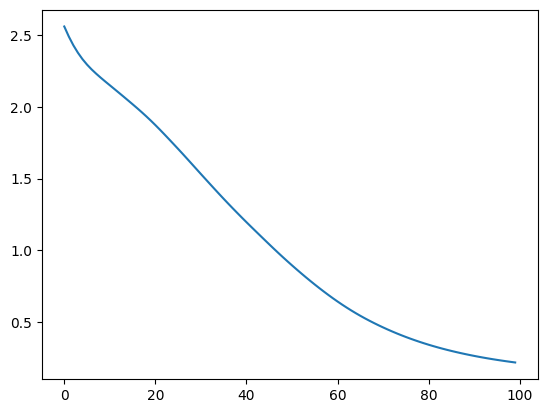

In [18]:
plt.plot(losses)